# Salary Predictions Based on Job Descriptions

## The goal: 
- Examine a set of job postings with salaries and then predict salaries for a new set of job postings

In [1]:
#Let's import the important libraries first to examine our data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import percentile
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
%matplotlib inline 

### 1. Getting the Data and Undertstanding the Dataset  

In [2]:
#loading the datasets from the desktop
df_train_features = pd.read_csv('C:\\Users\\Hazrat\\OneDrive\\Documents\\train_features.csv')
df_target_salaries = pd.read_csv('C:\\Users\\Hazrat\\OneDrive\\Documents\\train_salaries.csv')
df_test_features = pd.read_csv('C:\\Users\\Hazrat\\OneDrive\\Documents\\test_features.csv')

In [3]:
#quick overview of the dataset
df_train_features.head(5)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [4]:
# reviewing the target dataset 
df_target_salaries.head(5)

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163



### 2. Merging train and target  datasets before cleaning and we will leave the test_features set for prediction

In [38]:
#merging train_feature df with salary df
df_train = pd.merge(df_train_features, df_target_salaries, on='jobId')
df_train.head(5)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [39]:
#basic review of the rows and columns
df_train.shape

(1000000, 9)

In [40]:
#checking the categorical and numerical datatypes 
df_train.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

In [41]:
#additional examination of the data
df_train.info(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [42]:
#checking columns
df_train.columns

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis', 'salary'],
      dtype='object')

### 3. Checking the missing values & duplicates in the dataframe 

In [43]:
#checking for any missing values in the dataframe
missing_data = df_train.isnull().any()
missing_data

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
salary                 False
dtype: bool

In [44]:
#check for duplicates
clean_df = df_train.duplicated().sum()
clean_df

0

Based of on the above analysis we can see that the data does not have duplicates or missing values. We can move to statistical analysis of the dataset  

## EDA:

### 4.  Discriptive Statistics

In [45]:
#brief statistical overview of the dataframe
df_train.describe()

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


#### Visualize target variable (salary)

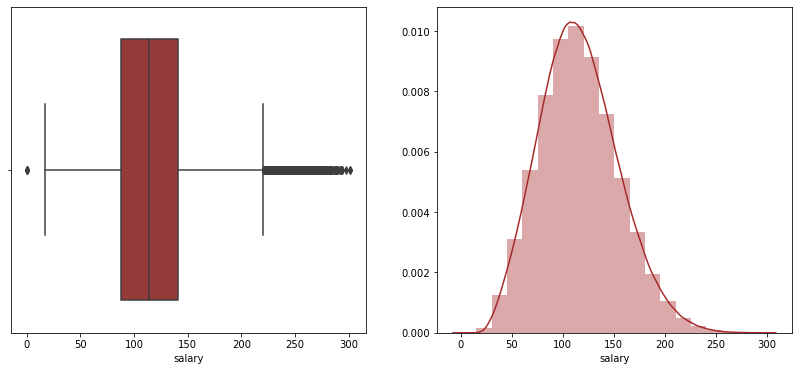

In [48]:
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(df_train.salary, color = 'brown')
plt.subplot(1,2,2)
sns.distplot(df_train.salary, bins=20, color = 'brown')
plt.show()

Looks like there some outliers on the target variable and we will examine further. We also noticed probability distribution looks Gausian.    

#### Finding and removing the outliers 

In [14]:
# calculate interquartile range
q25, q75 = percentile(df_train.salary, 25), percentile(df_train.salary, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in df_train.salary if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper, lower))

Percentiles: 25th=88.000, 75th=141.000, IQR=53.000
Identified outliers: 7122
The upper and lower bounds for suspected outliers are 220.5 and 8.5.


In [16]:
#potential outliers below lower bound
df_train[df_train.salary < 8.5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


These entries with zero salary do not appear to be volunteer positions. We are confident that they are instances of missing/corrupt data and should be removed from the dataset. Lets examines if outliers above 220.5 has similar issue. 

In [17]:
#outliers above upper bound
df_train.loc[df_train.salary > 220.5, 'jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

In [19]:
# Most suspicious potential outliers above upper bound
df_train[(df_train.salary > 220.5) & (df_train.jobType == 'JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
189582,JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
214606,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
427593,JOB1362684835280,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221


The outliers with high salaries appear to be correct data. Most roles are C-level executive roles and the junior positions are in industries that are well known for high salaries (oil, finance). We belive these entries to be legitimate and will not remove them. 

In [20]:
# Remove data with zero salaries
df_train = df_train[df_train.salary > 8.5]

### Examinining correlation between target and input variables  via regplot, boxplot and heatmap. 

(0.0, 316.05)

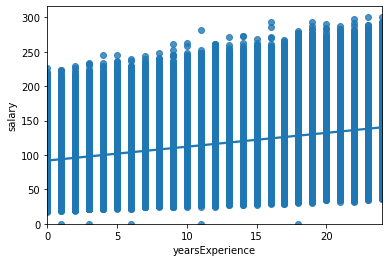

In [54]:
#checking years of experience correlation with target feature
sns.regplot(x="yearsExperience", y="salary", data=df_train)
plt.ylim(0,)

Based on the plot, we can see positive correlation between yearsExperince and salary features. Below we will examine the second numerical column with the target feature. 

(0.0, 316.05)

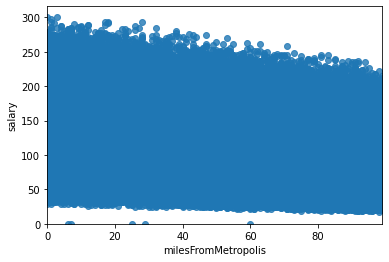

In [55]:
#the relation between milesFromMetropolis and target feature
sns.regplot(x="milesFromMetropolis", y="salary", data=df_train)
plt.ylim(0,)

The above plot shows that the futher employee lives From Metropolis, the lower salary expected. The relationship clear but not as strong as the yearsExperience feature.

#### Lets examine the Target Feature with Categorical Variables now  

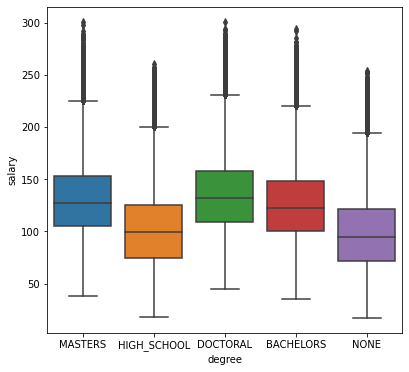

In [21]:
# how degree feature effects the saraly
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(x="degree", y="salary", data=df_train)

The boxplot above shows that PHD and Masters Degree get paid the highest. So meaning there clear correlation between "degree" and "salary" features. 

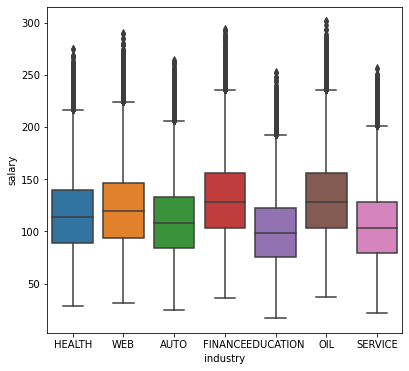

In [22]:
# industry feature and salary
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(x="industry", y="salary", data=df_train)

We noticed clear correlation between industry and salary with oil and finance getting paid the highest and education is lowest. 

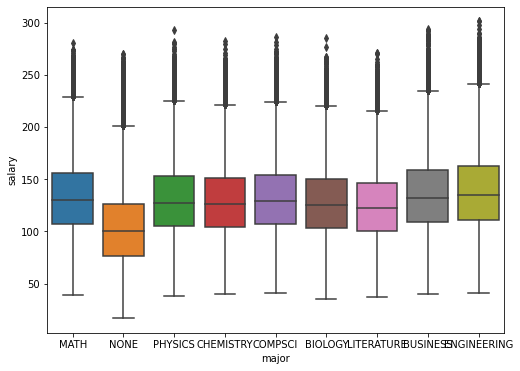

In [23]:
plt.figure(figsize = (18, 6))
plt.subplot(1,2,1)
sns.boxplot(x="major", y="salary", data=df_train)

The last categorical feature that we plot above is major. More advanced degrees tend to correspond to higher salaries.

#### Correlation Matrix

In [16]:
# Converting and replacing each category value with the average salary
# jobId is discarded because it is unique for individual
df_train_corr=['companyId','jobType','degree','major','industry']
def lab_enc(colm):
    for i in colm:
        df_train[i]=df_train.groupby(i).transform('mean')['salary']

In [17]:
lab_enc(df_train_corr)

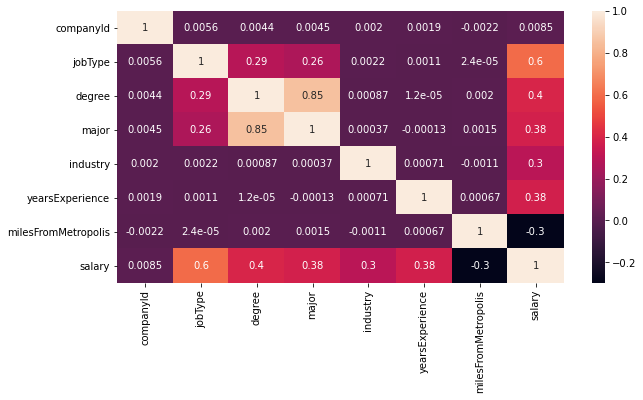

In [18]:
# Plotting the heatmap
plt.rcParams['figure.figsize'] = (10.0, 5.0)
sns.heatmap(df_train.corr(), annot = True)
plt.show()

Based on the above heatmap we see that the jobType is most strongly correlated with salary, followed by degree, major, and yearsExperience. Among the features, we see that degree and major have a strong degree of correlation and jobType has a moderate degree of correlation with both degree and major.

### 5. One-hot encoding on all categorical variables and combines result with continous variables

In [21]:
# Removing jobId coloumn
df_train.drop(columns =["jobId"], inplace = True)
df_test_features.drop(columns = ["jobId"], inplace = True)

In [22]:
#encode categorical data for Train df
cat_vars = ["companyId", "jobType", "degree", "major", "industry"]
num_vars = ["yearsExperience", "milesFromMetropolis"]
categorical_df = pd.get_dummies(df_train[cat_vars])
numerical_df = df_train[num_vars]
new_train_df = pd.concat([categorical_df, numerical_df], axis=1)
new_train_df.head(5)


,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,companyId_COMP13,companyId_COMP14,companyId_COMP15,companyId_COMP16,companyId_COMP17,...,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,10,83
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3,73
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,10,38
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,8,17
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,8,16


In [23]:
#encode categorical data for Test DF
cat_vars = ["companyId", "jobType", "degree", "major", "industry"]
num_vars = ["yearsExperience", "milesFromMetropolis"]
categorical_df = pd.get_dummies(df_test_features[cat_vars])
numerical_df = df_test_features[num_vars]
new_test_df = pd.concat([categorical_df, numerical_df], axis=1)
new_test_df.head(5)

,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,companyId_COMP13,companyId_COMP14,companyId_COMP15,companyId_COMP16,companyId_COMP17,...,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,22,73
1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,20,47
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,17,9
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,14,96
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,10,44


### 6. Choosing and training the models. Will do 5-fold cross validation on models and measure MSE

In [24]:
def train_model(model, new_train_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = cross_val_score(model, new_train_df, target_df, cv=5, n_jobs=num_procs, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)
    
def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation:\n', cv_std[model])


In [25]:
#get target df
target_df = df_train['salary'] 

#initialize model list and dicts
models = []
mean_mse = {}
cv_std = {}

#define number of processes to run in parallel
num_procs = 2

#create models -- hyperparameter tuning already done by hand for each model
lr = LinearRegression()
lr_std = make_pipeline(StandardScaler(), LinearRegression())
rf = RandomForestRegressor(n_estimators=60, n_jobs=num_procs, max_depth=25, min_samples_split=60, \
                               max_features=30)
gbm = GradientBoostingRegressor(n_estimators=40, max_depth=5, loss='ls')

models.extend([lr, lr_std, rf, gbm])

#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Cross validation")
for model in models:
    train_model(model, new_train_df, target_df, num_procs, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

Cross validation

Model:
 LinearRegression()
Average MSE:
 384.4643675263411
Standard deviation during CV:
 1.787176167234446

Model:
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])
Average MSE:
 384.4459697189462
Standard deviation during CV:
 1.7706836372125487

Model:
 RandomForestRegressor(max_depth=25, max_features=30, min_samples_split=60,
                      n_estimators=60, n_jobs=2)
Average MSE:
 366.659528107065
Standard deviation during CV:
 1.553171100929145

Model:
 GradientBoostingRegressor(max_depth=5, n_estimators=40)
Average MSE:
 398.37314825633126
Standard deviation during CV:
 1.8842388714285578


### 7. Will choose the model with lowest MSE and validate on test dataset 

In [27]:
#choose model with lowest mse
model = min(mean_mse, key=mean_mse.get)
print('\nPredictions calculated using model with lowest MSE:')
print(model)

#train model on entire dataset
model.fit(new_train_df, target_df)

#create predictions based on test data
predictions = model.predict(new_test_df)


Predictions calculated using model with lowest MSE:
RandomForestRegressor(max_depth=25, max_features=30, min_samples_split=60,
                      n_estimators=60, n_jobs=2)


### 8. Varifying feature that has strongest influence on salary  

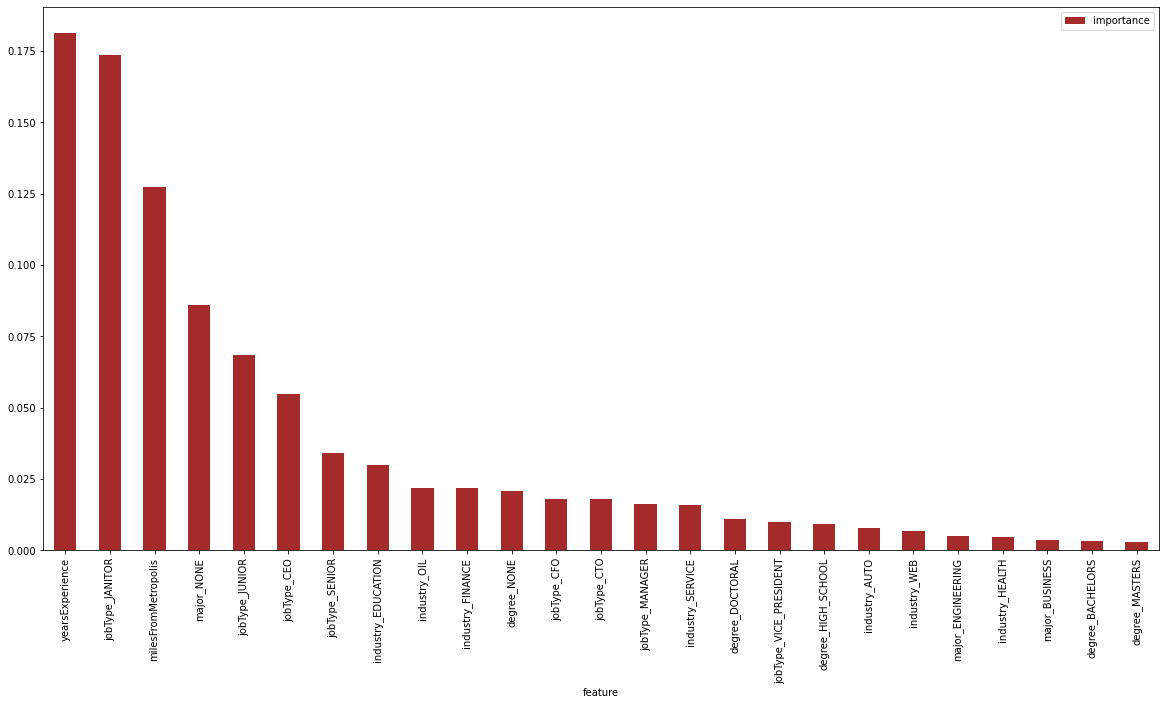

In [53]:
#store feature importances
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
    #linear models don't have feature_importances_
    importances = [0]*len(new_train_df.columns)
    
feature_importances = pd.DataFrame({'feature':new_train_df.columns, 'importance':importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
#set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)

feature_importances[0:25].plot.bar(figsize=(20,10), color = ['brown'])
plt.show()

### 9. PRODUCTION

In [59]:
#saving model, model summary, feature importances, and predictions
def save_results(model, mean_mse, predictions, feature_importances):
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('predictions.csv', predictions, delimiter=',')
    
#save results
save_results(model, mean_mse[model], predictions, feature_importances)

## Conclusion




After performing the EDA and predicting the model with the random forest algorithm and looking at the feature importance analysis, we can conclude that "year_of_experience" will have the highest impact on the target (salary) followed by "jobtype". In short, this salary prediction result along with the feature importance chart can help the companies to make better decision.

